# Bayes 3D Image Likelihood constrained to rays

TODO:

- [ ] Test for correctness
- [ ] Do performance evaluation and compare with 3dp3 Likelihood. Probably B3D is 2x slower.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#|default_exp likelihood

In [3]:
#|export
import jax
from jax import (jit, vmap)
import jax.numpy as jnp

import genjax
from genjax import gen, choice_map, vector_choice_map

import matplotlib.pyplot as plt
import numpy as np

import bayes3d
from bayes3d._mkl.utils import *

console = genjax.pretty(show_locals=False)
key     = jax.random.PRNGKey(0)

In [46]:
#|export
import genjax._src.generative_functions.distributions.tensorflow_probability as gentfp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

uniform = genjax.tfp_uniform

truncnormal = gentfp.TFPDistribution(
    lambda mu, sig, low, high: tfd.TruncatedNormal(mu, sig, low, high));

normal = gentfp.TFPDistribution(
    lambda mu, sig: tfd.Normal(mu, sig));

diagnormal = gentfp.TFPDistribution(
    lambda mus, sigs: tfd.MultivariateNormalDiag(mus, sigs));


mixture_of_diagnormals = gentfp.TFPDistribution(
    lambda logps, mus, sig: tfd.MixtureSameFamily(
        tfd.Categorical(logps),
        tfd.MultivariateNormalDiag(mus, sig * jnp.ones_like(mus))))


mixture_of_normals = gentfp.TFPDistribution(
    lambda ws, mus, sigs: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.Normal(mus, sigs)))


mixture_of_truncnormals = gentfp.TFPDistribution(
    lambda ws, mus, sigs, lows, highs: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.TruncatedNormal(mus, sigs, lows, highs)))

(100, 200, 3)


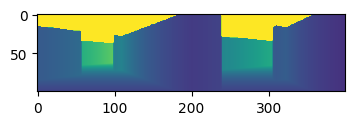

In [24]:
imgs = []
for t in range(10):
    im = np.load(f"./data/test_imgs/img_{t}.npy")
    imgs.append(jnp.array(im))

imgs = jnp.array(imgs)

X = imgs[7,:,:,:3]
Y = imgs[9,:,:,:3]

print(X.shape)
# ---------------------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([X[:,:,2],Y[:,:,2]], axis=1), vmin=0., vmax=5);

In [25]:
#|export
# Some helper to keep code concise
min = jnp.minimum
max = jnp.maximum


def dslice(X, i, j, w):     
    m = 2*w + 1
    return  jax.lax.dynamic_slice(X, (i, j, 0), (m, m, 3))   


def pad(X, w, val=-100.0):
    return jax.lax.pad(X,  val, ((w,w,0),(w,w,0),(0,0,0)))


def mix_std(ps, mus, stds):
    """Standard Deviation of a mixture of Gaussians."""
    return jnp.sqrt(jnp.sum(ps*stds**2) + jnp.sum(ps*mus**2) - (jnp.sum(ps*mus))**2)

## Baseline - Point cloud Model

In [41]:
#|export
def make_point_cloud_baseline_model(w, zmax):
    """Returns a uncostrained sensor model with a gaussian outlier model."""

    pad_val = -100.0

    @genjax.drop_arguments
    @gen
    def _sensor_model_ij(i, j, Y_, sig, outlier):
        
        ys = dslice(Y_, i, j, w).reshape(-1,3)

        ws = jnp.zeros(len(ys))
        # TODO: Does zero'ing out the padded values, create some
        # unwanted sideeffect?
        ws = jnp.where(ys[...,2] == pad_val, -jnp.inf, ws)
        ws = ws - logsumexp(ws)
        

        inlier_outlier_mix = genjax.tfp_mixture(genjax.tfp_categorical, 
            [mixture_of_diagnormals, diagnormal])
        
        x = inlier_outlier_mix([jnp.log(1.0-outlier), jnp.log(outlier)], (
                    (ws, ys, sig),
                    (jnp.zeros(3), zmax*jnp.ones(3))
                )) @ "measurement"

        return x


    @gen
    def sensor_model(Y, sig, outlier):    

        Y_ = pad(Y, w, val=pad_val)

        I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
        I, J = I.ravel(), J.ravel()
        
        X = genjax.Map(_sensor_model_ij, (0,0,None,None,None))(I,J,Y_,sig,outlier) @ "X"
        X = X.reshape(Y.shape)

        return X

    return sensor_model

In [42]:
w       = 2
zmax    = 20.
sig     = .01
outlier = 0.1

args = (Y[:,:], sig, outlier)
model = make_point_cloud_baseline_model(w, zmax)


key = keysplit(key)
tr = model.simulate(key, args)
ch = tr.strip()

display(tr.strip())
display(tr.get_selection())

└── :X
    └── (Vector)
        └── :measurement
            └──  f32[20000,3]

└── :X
    └── :measurement
        └── (All)

In [31]:
ch = genjax.choice_map({"X": 
        genjax.vector_choice_map({
            "measurement":  imgs[1,:,:,2].reshape(-1) 
        })
})

sel = genjax.select({"X":
    genjax.index_select([0],  genjax.select("measurement"))
})

pixel_addr = lambda i: genjax.select({"X":
    genjax.index_select(i,  genjax.select("measurement"))
})

inds = jnp.arange(tr["X", "measurement"].shape[0])
ps = vmap(lambda i: tr.project(pixel_addr(i)))(inds)
ps

Array([9.954826 , 9.953917 , 9.398294 , ..., 3.2605784, 9.503482 ,
       9.73508  ], dtype=float32)

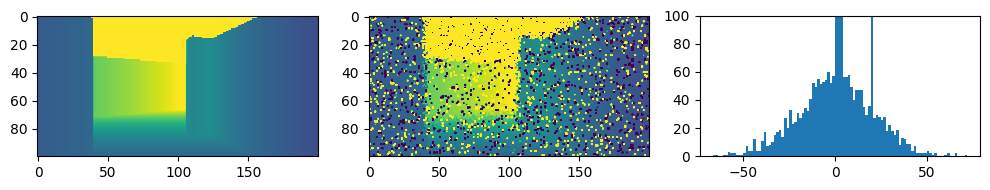

In [32]:
X = tr.get_retval()
# --------------------
fig, axs = plt.subplots(1,3, figsize=(10,2))
axs[0].imshow(Y[:,:,2], vmin=0, vmax=3.)
axs[1].imshow(X[:,:,2], vmin=0.0, vmax=3.)
axs[2].hist(X[:,:,2].reshape(-1), bins=100);
axs[2].set_ylim(0,100)
fig.tight_layout()

## Baselines - Constrained

### 1D Mixture Components

In [36]:
#|export
from scipy.stats import truncnorm as scipy_truncnormal

normal_logpdf    = jax.scipy.stats.norm.logpdf
truncnorm_logpdf = jax.scipy.stats.truncnorm.logpdf
truncnorm_pdf    = jax.scipy.stats.truncnorm.pdf

[<matplotlib.lines.Line2D object at 0x7f12fd576ca0>]

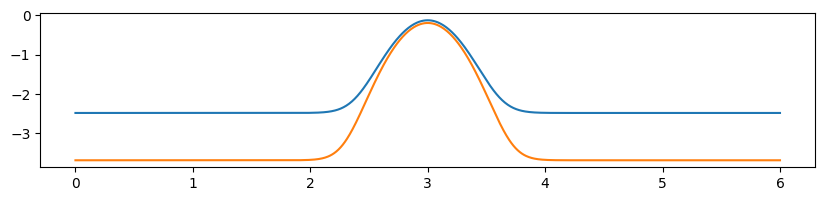

In [104]:
mix = genjax.tfp_mixture(genjax.tfp_categorical, [normal, uniform])

outlier = 0.5
mu  = 3.0
sig = 0.25
zmax = 6.0

ws = [jnp.log(1.0-outlier), jnp.log(outlier)]


xs = jnp.linspace(0.0,6.0, 1_000)
ys = vmap(mix.logpdf, (0,None,None))(xs, ws, ((mu, sig), (0.0, zmax)))

outlier = 0.5
ws = [jnp.log(1.0-outlier), jnp.log(outlier)]
ys2 = vmap(mix.logpdf, (0,None,None))(xs, ws, ((mu, sig), (0.0, 20.)))


plt.figure(figsize=(10,2))
# plt.ylim(0,1)
plt.plot(xs, ys)
plt.plot(xs, ys2)

[<matplotlib.lines.Line2D object at 0x7f12fd115df0>]

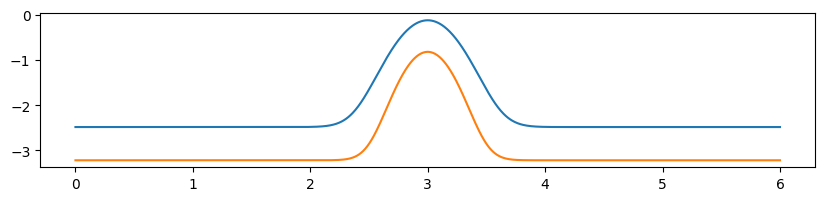

In [114]:
mix = genjax.tfp_mixture(genjax.tfp_categorical, [truncnormal, uniform])

outlier = 0.5
mu  = 3.0
sig = 0.25
zmax = 6.0

ws = [jnp.log(1.0-outlier), jnp.log(outlier)]


xs = jnp.linspace(0.0,6.0, 1_000)
ys = vmap(mix.logpdf, (0,None,None))(xs, ws, ((mu, sig, 0.0, zmax), (0.0, zmax)))

sig = 0.2
outlier = 0.8
ws = [jnp.log(1.0-outlier), jnp.log(outlier)]
ys2 = vmap(mix.logpdf, (0,None,None))(xs, ws, ((mu, sig,0.0, zmax), (0.0, 20.)))


plt.figure(figsize=(10,2))
# plt.ylim(0,1)
plt.plot(xs, ys)
plt.plot(xs, ys2)

In [37]:
#|export
def get_1d_mixture_components(x, ys, sig, val=-100.0):

    # 1D-Mixture components and value to evaluate.
    # These are given by the distances ALONG ray through `x`
    d  = jnp.linalg.norm(x, axis=-1)
    ds = ys @ x / d
    
    # 1D-Mixture weights.
    # First compute the distances TO ray through `x`
    # and then transforming them appropriately.
    ws = jnp.linalg.norm(ds[...,None] * x/d - ys, axis=-1)
    ws = normal_logpdf(ws, loc=0.0, scale=sig)

    return d, ds, ws

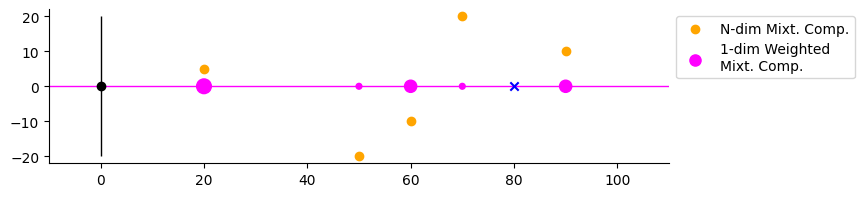

In [38]:
sig  = 10.
zmax = 100.
x  = jnp.array([0.,0, 0.8*zmax])
ys = jnp.array([ 
    [-20, 0, 50],
    [-10, 0, 60],
    [10, 0, 90],
    [20, 0, 70],
    [5, 0, 20],
])


d, ds, ws = get_1d_mixture_components(x, ys, sig)
ws = ws - logsumexp(ws, axis=-1)

# ------------------------------
fig, ax = plt.subplots(1,1, figsize=(8,2), sharex=True)
ax.set_xlim(-0.1*zmax,1.1*zmax)
ax.scatter(ys[:,2], ys[:,0], c="orange", label="N-dim Mixt. Comp.")
ax.scatter(ds, jnp.zeros(len(ds)),  s=jnp.exp(ws)*300, c="magenta", label="1-dim Weighted\nMixt. Comp.")
ax.scatter(d, x[0],marker="x", c="blue");
ax.hlines(0, -0.1*zmax,1.1*zmax, color="magenta", zorder=-1, linewidth=1.)
ax.vlines(0, jnp.min(ys[:,0]), jnp.max(ys[:,0]), color="k", zorder=-1, linewidth=1.)
ax.scatter(0,0, c="k")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [39]:
def check_image(X, zmax):
    D = jnp.linalg.norm(X[:,:,:3], axis=2)
    zmax_ = D/X[:,:,2]*zmax
    X_ = jnp.where( D[:,:,None] <= zmax_[:,:,None], X, zmax_[:,:,None]*X/D[:,:,None])
    return D <= zmax_, X_

### Constrained and Untruncated

In [43]:
#|export
# TODO: The input Y should be an array only containing range measruements as well. 
#       For this to work we need to have the pixel vectors (the rays through each pixel)

def make_constrained_baseline_model(w, zmax):
    """Returns a untruncated constrained sensor model marginalized over outliers."""    

    pad_val = -100.0

    @genjax.drop_arguments
    @gen
    def _sensor_model_ij(i, j, Y_, sig, outlier):

        # Note that `i,j` are at the edge of the filter window,
        # the Center is offset by `w``
        y  = Y_[i+w,j+w] 
        ys = dslice(Y_, i, j, w).reshape(-1,3)
        
        d, ds, ws = get_1d_mixture_components(y, ys, sig)

        ws = jnp.where(ys[...,2] == pad_val, -jnp.inf, ws)
        ws = ws - logsumexp(ws)

        inlier_outlier_mix = genjax.tfp_mixture(genjax.tfp_categorical, [
                                mixture_of_normals, genjax.tfp_uniform])

        zmax_ = d/y[2]*zmax

        z = inlier_outlier_mix([jnp.log(1.0-outlier), jnp.log(outlier)], (
                                    (ws, ds, sig), 
                                    (0.0, zmax_))) @ "measurement"

        return z * y/d

        
    @gen
    def sensor_model(Y, sig, outlier):   
        """Constrained sensor model."""
        Y_ = pad(Y, w, val=pad_val)

        I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
        I, J = I.ravel(), J.ravel()
                
        
        X = genjax.Map(_sensor_model_ij, (0,0,None,None,None))(I, J, Y_, sig, outlier) @ "X"
        X = X.reshape(Y.shape)

        return X

    return sensor_model

In [44]:
w       = 2
zmax    = 20.
sig     = .01
outlier = 0.1

args = (Y[:,:], sig, outlier)
model = make_constrained_baseline_model(w, zmax)


key = keysplit(key)
tr = model.simulate(key, args)
ch = tr.strip()

display(tr.strip())
display(tr.get_selection())

└── :X
    └── (Vector)
        └── :measurement
            └──  f32[20000]

└── :X
    └── :measurement
        └── (All)

In [72]:
#|export
# TODO: The input Y should be an array only containing range measruements as well. 
#       For this to work we need to have the pixel vectors (the rays through each pixel)

def make_truncated_constrained_baseline_model(w, zmax):
    """Returns a truncated constrained sensor model marginalized over outliers."""    
    pad_val = -100.0

    @genjax.drop_arguments
    @gen
    def _sensor_model_ij(i, j, Y_, sig, outlier):

        # Note that `i,j` are at the edge of the filter window,
        # the Center is offset by `w``
        y  = Y_[i+w,j+w] 
        ys = dslice(Y_, i, j, w).reshape(-1,3)
        
        d, ds, ws = get_1d_mixture_components(y, ys, sig)

        ws = jnp.where(ys[...,2] == pad_val, -jnp.inf, ws)
        ws = ws - logsumexp(ws)


        inlier_outlier_mix = genjax.tfp_mixture(genjax.tfp_categorical, [
                                mixture_of_truncnormals, genjax.tfp_uniform])

        zmax_ = d/y[2]*zmax
        # zmax_ = zmax
        
        z = inlier_outlier_mix([jnp.log(1.0-outlier), jnp.log(outlier)], (
                                    (ws, ds, sig,0.0,zmax_), 
                                    (0.0, zmax_))) @ "measurement"


        return z * y/d

        
    @gen
    def sensor_model(Y, sig, outlier):   
        """Constrained sensor model."""
        Y_ = pad(Y, w, val=pad_val)

        I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
        I, J = I.ravel(), J.ravel()
                
        
        X = genjax.Map(_sensor_model_ij, (0,0,None,None,None))(I, J, Y_, sig, outlier) @ "X"
        X = X.reshape(Y.shape)

        return X

    return sensor_model

In [71]:
w       = 2
zmax    = 20.
sig     = .01
outlier = 0.1

args = (Y[:,:], sig, outlier)
model = make_truncated_constrained_baseline_model(w, zmax)


key = keysplit(key)
tr = model.simulate(key, args)
ch = tr.strip()

display(tr.strip())
display(tr.get_selection())

└── :X
    └── (Vector)
        └── :measurement
            └──  f32[20000]

└── :X
    └── :measurement
        └── (All)

<hr style="border-bottom: 20px solid black; width:50%; margin-left: 0;"/>

In [59]:
# TODO: The input Y should be an array only containing range measruements as well. 
#       For this to work we need to have the pixel vectors (the rays through each pixel)

def make_marginalized_baseline_model_3(w, zmax):
    """Returns a constrained sensor model marginalized over outliers."""    

    pad_val = -100.0

    @genjax.drop_arguments
    @gen
    def _sensor_model_ij(i, j, Y_, sig, outlier):
        y  = Y_[i+w,j+w]

        ys = dslice(Y_, i, j, w).reshape(-1,3)
        
        d, ds, ws = get_1d_mixture_components(y, ys, sig)

        ws = jnp.where(ys[...,2] == pad_val, -jnp.inf, ws)
        ws = ws - logsumexp(ws)

        zmax_ = d*zmax/y[2]

        inlier_outlier_mix = genjax.tfp_mixture(genjax.tfp_categorical, [
                                mixture_of_normals, genjax.tfp_uniform])

        in_args   = (ws, ds, sig)
        out_args  = (0.0, zmax_)
        in_out_ws =  [jnp.log(1.0-outlier), jnp.log(outlier)]

        z = inlier_outlier_mix(in_out_ws, (in_args, out_args)) @ "measurement"

        return z * y/d

        
    @gen
    def sensor_model(Y, sig, outlier):   
        """Constrained sensor model."""
        Y_ = pad(Y, w, val=pad_val)

        I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
        I, J = I.ravel(), J.ravel()
                
        
        X = genjax.Map(_sensor_model_ij, (0,0,None,None,None))(I, J, Y_, sig, outlier) @ "X"
        X = X.reshape(Y.shape)

        return X

    return sensor_model

In [54]:
w    = 2
sig  = .1
zmax = 20.
outlier = 0.1

args = (Y[:,:], sig, outlier)
model = make_marginalized_baseline_model(w, zmax)

key = keysplit(key)
tr = model.simulate(key, args)
ch = tr.strip()
ch

└── :X
    └── (Vector)
        └── :measurement
            └──  f32[20000]

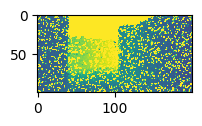

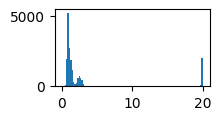

In [58]:
X = tr.get_retval()
# --------------------
plt.figure(figsize=(2,2))
plt.imshow(X[:,:,2], vmin=0.0, vmax=3.)

# --------------------
plt.figure(figsize=(2,1))
plt.hist(X[:,:,2].reshape(-1), bins=100);

In [15]:
w   = 2
sig = .1
zmax = 20.

args = (Y[:,:], sig)
model = make_constrained_baseline_model(w, zmax, 
    truncated=True, 
    mixture=False)

key = keysplit(key)
tr = model.simulate(key, args)
ch = tr.strip()
ch

└── :X
    └── (Vector)
        └── :measurement
            └──  f32[20000]

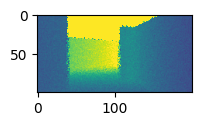

In [16]:
X = tr.get_retval()
# --------------------
plt.figure(figsize=(2,2))
plt.imshow(X[:,:,2], vmin=0.0, vmax=3.)

In [38]:
w   = 2
sig = .1
zmax = 20.
outlier = 0.1

args = (Y[:,:], sig, outlier)
model = make_marginalized_baseline_model(w, zmax)


In [39]:
ch = genjax.choice_map({"X": 
        genjax.vector_choice_map({
            "measurement":  imgs[1,:,:,2].reshape(-1) 
        })
})

key = keysplit(key)
(w, tr) = model.importance(key, ch, args)
print(w, tr.get_score())
tr.strip()

-78268.25 -78268.25


└── :X
    └── (Vector)
        └── :measurement
            └──  f32[20000]

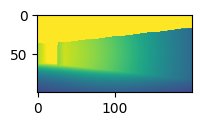

In [21]:
X = tr.get_retval()
# --------------------
plt.figure(figsize=(2,2))
plt.imshow(X[:,:,2], vmin=0.0, vmax=3.)

In [ ]:
# from genjax._src.core.datatypes.generative import ChoiceMap
# from genjax._src.generative_functions.combinators.vector.vector_datatypes import (
#     VectorChoiceMap,
#     IndexChoiceMap
# )


# def make_constraint(addr:tuple, data, ch):

#     l = len(addr)
#     d = None


#     addr = list(map(lambda a: a if isinstance(a, tuple) else (a,None) , addr))
#     addr, aux = list(zip(*addr))
    
#     for i in range(len(addr)):
#         a = addr[:l-i]
#         if isinstance(ch[a], ChoiceMap):
#             t = type(ch[a])
#             if isinstance(ch[a], IndexChoiceMap):
#                 x = aux[l-i-1]
#                 d = genjax.choice_map({a[-1]: t(x,d)})
#             else:
#                 d = genjax.choice_map({a[-1]: t(d)})
#         else:
#             d = genjax.choice_map({a[-1]: data})

#     return d



# ch = genjax.choice_map({"X": 
#         genjax.vector_choice_map(
#             genjax.choice_map({"ij":  jnp.ones((200,3))})
#         )
# })
# constr = make_constraint(("X", "ij"), jnp.ones((200,3)), ch)
# constr

In [115]:
w   = 2
sig = .1
zmax = 30.

args = (Y[:10,:20], sig)
# model = make_baseline_model(w)
model = make_constrained_baseline_model(w, zmax)

In [118]:
ch = genjax.choice_map({"X": 
        genjax.vector_choice_map({
            "measurement":  jnp.ones((200,3)) 
        }) 
})

ch = genjax.choice_map({"X": 
        genjax.index_choice_map([0,1], {
            "measurement":  jnp.ones((2,)) 
        }) 
})

# ch
# from genjax._src.core.datatypes.generative import ChoiceMap, HierarchicalChoiceMap
# from genjax._src.core.datatypes.trie import Trie


key = keysplit(key)
(_, tr) = model.importance(key, ch, args)
tr["X"]["measurement"][:4]

Array([1.       , 1.       , 1.2348325, 1.3342507], dtype=float32)

In [80]:
tr.strip()

└── :X
    └── (Vector)
        └── :measurement
            └──  f32[200,3]

In [54]:
ch = genjax.choice_map({"X": 
        genjax.index_choice_map([0,1],
            genjax.choice_map({ "ij":  jnp.ones((2,3)) }) 
        )
})

args = (Y[:10,:20], sig)
(_, tr) = sensor_model.importance(key, ch, args)
print(tr["X"]["ij"][:4])
tr.strip()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_4421/3625680606.py:8 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_4421/3625680606.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'sensor_model' is not defined

In [632]:
# genjax.index_select(("X", 0))
?genjax.select

Signature: genjax.select(*addrs)
Docstring: <no docstring>
File:      ~/workspace/genjax/src/genjax/_src/core/datatypes/generative.py
Type:      method

In [659]:
?genjax.vector_select

Signature:
genjax.vector_select(
    inner: genjax._src.core.datatypes.generative.Selection,
)
Docstring:
----------------------------------

new(cls, *args: Union[tuple, str])
File:      ~/workspace/genjax/src/genjax/_src/generative_functions/combinators/vector/vector_datatypes.py
Type:      method

In [665]:
genjax.vector_select(("X")).filter(tr.strip()["X"])

└── (Vector)

In [ ]:
tr.project(genjax.vector_select(("X")))

In [54]:
jsampler = jit(sensor_model.sample)
jsimulater = jit(sensor_model.simulate)

In [55]:
jsampler(key, Y[:10,:20], sig);
jsimulater(key, (Y[:10,:20], sig));

(100, 200, 3)


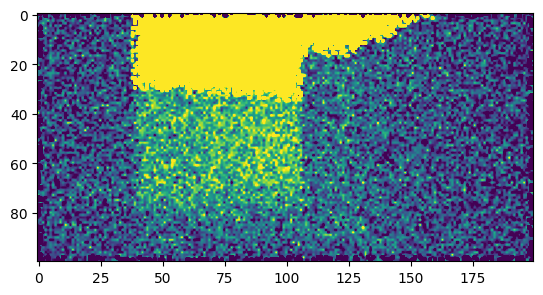

In [56]:
X = jsampler(key, Y[:,:], sig);
print(X.shape)

plt.imshow(X[:,:,2], vmin=0, vmax=4)

In [ ]:
import functools
from jax.experimental import checkify

def constrained_lh_mix(x, ys, zmax, sig, outlier):
    # assert , 
    # checkify.check(x[2] > 0.0, "z-coords need to be > 0, but you try to evaluate x = {x} ", x=x)
    

    d, ds, ws = get_1d_mixture_components(x, ys, sig)
    
    # Adjusted zmax: the range at which x intersects the far plane
    # Depends on the behaviour we want...
    zmax_ = d/x[2]*zmax
    
    # TODO: should we clip actually??
    d = jnp.clip(d, 0.0, zmax_)

    logps = truncnorm_logpdf(d, (0.0 - ds)/sig, (zmax_ - ds)/sig, loc=ds, scale=sig)
    logp  = logsumexp(logps + ws)

    logp  = jnp.logaddexp(logp + jnp.log(1.0 - outlier), jnp.log(outlier) - jnp.log(zmax_))
    
    return jnp.where(x[2] <= 0.0, -jnp.inf, logp)

In [ ]:
zmax = 100.0
sig  = 10.
outlier = 0.5

x  = jnp.array([0.,0, 0.8*zmax])
ys = jnp.array([ 
    [-20, 0, 50],
    [-10, 0, 60],
    [10, 0, 90],
    [20, 0, 70],
    [5, 0, 20],
])


d, ds, ws = get_1d_mixture_components(x, ys, sig)

logp = constrained_lh_mix(x, ys, zmax, sig, outlier)
print(logp)

xs = jnp.linspace(-0.1, 1.1, 1_000)[:,None] * jnp.array([0.0,0.0,zmax])[None,]
print(xs[0], xs[-1])

logps = jax.vmap(constrained_lh_mix, (0,None,None,None,None))(xs, ys, zmax, sig, outlier)

print(np.min(logps), np.max(logps))

# ------------------------------
fig, axs = plt.subplots(2,1, figsize=(10,4), sharex=True)

axs[0].set_xlim(-0.1*zmax,1.1*zmax)
axs[0].scatter(ys[:,2], ys[:,0], c="orange")
axs[0].scatter(ds, jnp.zeros(len(ds)),  s=jnp.exp(ws)*300, c="magenta")
axs[0].scatter(d, x[0],marker="x", c="blue");
axs[0].hlines(0, -0.1*zmax,1.1*zmax, color="magenta", zorder=-1, linewidth=0.2)

axs[1].plot(xs[:,2], jnp.exp(logps), c="magenta")
axs[1].scatter(x[2], 0.0, marker="x", c="b")
axs[1].vlines(zmax, 0, jnp.max(jnp.exp(logps)), color="b", linestyle="--")
axs[1].vlines( 0.0, 0, jnp.max(jnp.exp(logps)), color="b", linestyle="--")

In [ ]:
#|export
def constrained_lh_mix_ij(i,j, X, Y_padded, zmax, sig, outlier, w):
    x  = X[i, j, :3]
    ys = dslice(Y_padded, i,j, w)

    return constrained_lh_mix(x, ys, zmax=zmax, sig=sig, outlier=outlier)



def constrained_lh(X, Y, zmax, sig, outlier, w:int):
    """"Likelihood of observation X conditioned on Y."""
    Y_   = jax.lax.pad(Y,  -100., ((w,w,0),(w,w,0),(0,0,0)) )
    
    J, I = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))
    I = I.ravel()
    J = J.ravel()

    f_ij  = lambda i,j: constrained_lh_mix_ij(i, j, X[:,:,:3], Y_[:,:,:3], zmax=zmax, sig=sig, outlier=outlier, w=w) 
    logps = jax.vmap(f_ij)(I, J)

    return logps.sum()


constrained_lh_jit = jit(constrained_lh,static_argnames=("w",))

In [ ]:
def baseline_ij(
    i, j,
    observed_xyz: jnp.ndarray,
    rendered_xyz_padded: jnp.ndarray,
    variance,
    filter_size: int,
):
    distances = (
        observed_xyz[i, j, :3] - 
        jax.lax.dynamic_slice(rendered_xyz_padded, (i, j, 0), (2*filter_size + 1, 2*filter_size + 1, 3))
    )
    probability = jax.scipy.special.logsumexp(
        jax.scipy.stats.norm.logpdf(
            distances,
            loc=0.0,
            scale=jnp.sqrt(variance)
        ).sum(-1) - jnp.log((2*filter_size + 1)**2)
    )
    return probability

In [ ]:
zmax    = 20.1
sig     = .5
var     = sig**2
w       = 3
outlier = 0.0

X = imgs[2,:,:,:3]
Y = imgs[2,:,:,:3]
Y_ = pad(Y, w)


J, I = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))
I = I.ravel()
J = J.ravel()


P = jax.vmap(constrained_lh_mix_ij, (0,0,None,None, None,None,None,None))(I, J, X, Y_, zmax, sig, outlier, w)
Q = jax.vmap(baseline_ij, (0,0,None,None, None,None))(I, J, X, Y_, var, w)
P = P.reshape(X.shape[:2])
Q = Q.reshape(X.shape[:2])


fig, axs = plt.subplots(1,2, figsize=(8,2))
axs[0].set_title("B3D")
axs[0].imshow(P)
axs[1].set_title("3DP3")
axs[1].imshow(Q)

plt.figure(figsize=(4,1))
plt.hist(jnp.exp(P-Q).ravel(), bins=100);

In [ ]:
zmax    = 20.
sig     = .5
var     = sig**2
outlier = 0.2
outlier_vol = 100. 
w       = 4

args = (zmax, sig, outlier, w)


X = imgs[2,:,:,:3]
Y = imgs[5,:,:,:3]


print(X.shape[0]*X.shape[1]*truncnorm_logpdf(zmax/2, (0.0 - zmax/2)/sig, (zmax - zmax/2)/sig, loc=zmax/2, scale=sig))

logp = constrained_lh_jit(X, Y, *args)
print(logp)
print(logp - jnp.log(X.shape[0]*X.shape[1]))

plt.figure(figsize=(8,2))
plt.imshow(jnp.concatenate([X[:,:,2],Y[:,:,2]], axis=1), vmin=0., vmax=5)

In [ ]:
def img_mean_and_var(X, zmax, sig, w):

    # Pixel-wise mean and var
    def mean_and_var_ij(i,j):        

        x  = X[i, j, :3]
        ys = dslice(pad(X,w), i,j, w)
        # ys = adjusted_dslice(X,i,j,w)

        d, ds, ws = get_1d_mixture_components(x, ys, sig)

        mu  = jnp.sum(jnp.exp(ws)*ds)
        std = mix_std(jnp.exp(ws), ds, sig)

        return mu, std**2

    I, J = jnp.mgrid[:X.shape[0], :X.shape[1]]
    I = I.ravel()
    J = J.ravel()

    mu, var = vmap(mean_and_var_ij)(I, J)
    return mu.reshape(*X.shape[:2]), var.reshape(*X.shape[:2])

In [ ]:
zmax = 20.0
sig  = .2
out  = 0.1
w    = 11

mu, var  = img_mean_and_var(X, zmax, sig, w)
std = jnp.sqrt(var)
print(mu.shape)
print(mu[0,0])

# -------------------------
vmin = 0.
vmax = 5.
fig, axs = plt.subplots(1,3, figsize=(10,3))
fig.suptitle(f"w={w}, sig={sig}")
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

axs[0].set_title("original")
axs[0].imshow(X[:,:,2], vmin=vmin, vmax=vmax, cmap="binary_r")
axs[1].set_title("Mean")
axs[1].imshow(mu, vmin=vmin, vmax=vmax, cmap="binary_r")
axs[2].set_title("Std. Dev.")
axs[2].imshow(std, vmin=vmin, vmax=vmax, cmap="binary_r");
fig.tight_layout(rect=[0, 0.03, 1., 1.])

In [ ]:
X = imgs[10,:,:,:]
Y = imgs[2,:,:,:]
zmax=20.
sig=0.2
outlier=0.1
w= 5
args = (zmax, sig, outlier, w)

constrained_lh(X, Y, *args)
%timeit -n 1 -r 1 constrained_lh(X, Y, *args);

In [ ]:
pad_jit(X, w);

In [ ]:
#|export
from genjax.generative_functions.distributions import ExactDensity

class B3DImageLikelihood(ExactDensity):
    def sample(self, key, Y, zmax, sig, outlier, w:int):
        # TODO: write this method
        return Y

    def logpdf(self, X, Y, zmax, sig, outlier, w:int):
        return constrained_lh_jit(X, Y, zmax, sig, outlier, w)

b3d_image_likelihood = B3DImageLikelihood()


## Testing

In [ ]:
zmax = 100.0
sig = 0.1
out = 0.1
w = 21

constrained_lh(X, Y, zmax, sig, out, w)

In [ ]:
zmax = 100.0
sig = 10.0

x  = jnp.array([0.,67.,0.])
ys = jnp.array([ 
    [-20, 50, 0],
    [-10, 60, 0],
    [10, 90, 0],
    [20, 70, 0],
    [5, 20, 0],
])


z = jnp.linalg.norm(x)

zs_ = ys @ x / z
ws_ = jnp.linalg.norm(zs_[...,None] * x/z - ys, axis=-1)
ws_ = normal_logpdf(ws_, loc=0.0, scale=sig)
ws_ = ws_ - logsumexp(ws_)
logps = truncnorm_logpdf(z, (0.0 - zs_)/sig, (zmax - zs_)/sig, loc=zs_, scale=sig)
logp  = logsumexp(logps + ws_)


vs = zs_[...,None] * x/z



# ------------------------------
plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.scatter(ys[:,0], ys[:,1], c="orange")
plt.scatter(vs[:,0], zs_,  s=jnp.exp(ws_)*2_00, c="magenta")
plt.scatter(x[0], z, marker="x", c="blue");

In [ ]:
xs = jnp.linspace(0.0, zmax, 100)[:,None] * x/z


ps = vmap(lambda x: constrained_lh_mix(x, ys, zmax=100.0, sig=10.))(xs)

plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.scatter(xs[:,0], xs[:,1], c = ps)
plt.scatter(ys[:,0], ys[:,1])

In [ ]:
plt.figure(figsize=(4,1))
plt.plot(jnp.exp(ps), marker=".")

In [ ]:
imgs = []
for t in range(10):
    im = np.load(f"./data/test_imgs/img_{t}.npy")
    imgs.append(jnp.array(im))

imgs = jnp.array(imgs)
imgs.shape


X = imgs[3]
Y = imgs[2]


plt.imshow(jnp.concatenate([X[:,:,2],Y[:,:,2]]), vmin=0., vmax=5)

In [ ]:


# J, I = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))
# I.shape, J.shape
# jj, ii = jnp.meshgrid(jnp.arange(X.shape[1]), jnp.arange(X.shape[0]))
# indices = jnp.stack([ii,jj],axis=-1)
# indices.shape